In [67]:
using StatsBase
using Plots
using JLD2
using Graphs
# using SimpleWeightedGraphs
using BlossomV

In [2]:
function initialstate(L::Int)
    ρ = zeros(Bool,L,L)
    return ρ
end

function noiselayer(ρ::AbstractMatrix, p::Float64)
    L = size(ρ)[1]
    noise = rand(L,L) .< p
    return ρ .⊻ noise
end

function magnetization(ρ::AbstractMatrix)
    return mean(ρ)
end

magnetization (generic function with 1 method)

In [217]:
function measure(ρ::AbstractMatrix, q::Float64)
    vertical_checks = noiselayer(ρ .⊻ circshift(ρ,(-1,0)),q)
    horizontal_checks = noiselayer(ρ .⊻ circshift(ρ,(0,-1)),q)
    return vertical_checks, horizontal_checks
end

function detect_charges(vertical_checks::AbstractMatrix, horizontal_checks::AbstractMatrix)
    L = size(vertical_checks)[1]
    sites = vertical_checks .⊻ horizontal_checks .⊻ circshift(vertical_checks,(0,-1)) .⊻ circshift(horizontal_checks,(-1,0))
    return [(j,i) for i in 1:L, j in 1:L][sites]
end

function distance(L::Int, p1::Tuple{Int,Int}, p2::Tuple{Int,Int})
    x1, y1 = p1
    x2, y2 = p2
    dx = min(abs(x2-x1),L-abs(x2-x1))
    dy = min(abs(y2-y1),L-abs(y2-y1))
    return dx, dy, abs(x2-x1) > L-abs(x2-x1), abs(y2-y1) > L-abs(y2-y1)
end

function match_charges(L::Int, charges::Vector; depth=50)
    subgraph = complete_graph(length(charges))
    weights = Dict{Edge,Float64}()
    for i in 1:length(charges)-1
        for j in i+1:length(charges)
            dx, dy, _, _ = distance(L, charges[i], charges[j])
            weights[Edge(i, j)] = dx+dy
        end
    end

    match = minimum_weight_perfect_matching(subgraph, weights, depth)
    return match
end

function heal(vertical_checks::AbstractMatrix, horizontal_checks::AbstractMatrix)
    L = size(vertical_checks)[1]
    charges = detect_charges(vertical_checks, horizontal_checks) 
    if length(charges) == 0
        return vertical_checks, horizontal_checks
    end
    pairings = match_charges(L, charges)
    paired = Int[]
    
    vertical_flips = BitMatrix(zeros(Bool, L, L))
    horizontal_flips = BitMatrix(zeros(Bool, L, L))
    for i in 1:length(charges)
        if i in paired
            continue
        end
        j = pairings.mate[i]
        push!(paired, j)
        
        dx, dy, x_loop, y_loop = distance(L, charges[i], charges[j])
        x_dir = (-1)^((charges[i][1] > charges[j][1]) ⊻ x_loop)
        y_dir = (-1)^((charges[i][2] > charges[j][2]) ⊻ y_loop)
    
        
        
        y_steps = sample(1:dx+dy, dy, replace=false)
        
        pos = charges[i]
        for step in 1:dx+dy
            x, y = pos
            if step in y_steps
                if y_dir == 1
                    horizontal_flips[mod1(y+1,L),x] ⊻= true
                else
                    horizontal_flips[y,x] ⊻= true
                end
                pos = (x, mod1(y+y_dir,L))
            else
                if x_dir == 1
                    vertical_flips[y,mod1(x+1,L)] ⊻= true
                else
                    vertical_flips[y,x] ⊻= true
                end
                pos = (mod1(x+x_dir,L), y)
            end
        end
    end
    return vertical_checks .⊻ vertical_flips, horizontal_checks .⊻ horizontal_flips
end

function build_correction(vertical_checks::AbstractMatrix, horizontal_checks::AbstractMatrix)
    L = size(vertical_checks)[1]
    domains = BitMatrix(zeros(Bool, L, L))
    for y in 1:L
        for x in 2:L
            domains[y,x] = domains[y,x-1] ⊻ horizontal_checks[y,x-1]
        end
        if y < L
            domains[y+1,1] = domains[y,1] ⊻ vertical_checks[y,1]
        end
    end
    
    if mean(domains) <= 0.5
        return domains
    else
        return true .⊻ domains
    end
end

function mwpm(ρ::AbstractMatrix, checks::Tuple)
    vertical_checks, horizontal_checks = checks
    ρ = ρ .⊻ build_correction(heal(vertical_checks, horizontal_checks)...)
    return ρ
end

mwpm (generic function with 1 method)

In [265]:
data

Dict{Tuple{Float64, Float64}, Array} with 19 entries:
  (8.0, 0.05)   => Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 ……
  (12.0, 0.06)  => Bool[0 0 … 0 0; 0 0 … 1 1; … ; 0 0 … 1 0; 0 0 … 0 0;;; 0 0 ……
  (4.0, 0.1)    => Bool[0 0 … 0 0; 0 0 … 0 1; … ; 0 1 … 1 1; 0 0 … 0 0;;; 0 0 ……
  (8.0, 0.06)   => Bool[0 0 … 0 0; 0 0 … 1 1; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 ……
  (8.0, 0.069)  => Bool[1 1 … 0 0; 1 1 … 0 1; … ; 1 1 … 1 0; 1 1 … 1 1;;; 1 1 ……
  (16.0, 0.07)  => Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 1 1;;; 0 0 ……
  (20.0, 0.07)  => Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 ……
  (12.0, 0.07)  => Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 1;;; 0 0 ……
  (8.0, 0.07)   => Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 ……
  (12.0, 0.1)   => Bool[0 0 … 0 0; 0 0 … 0 1; … ; 0 0 … 0 0; 0 0 … 1 1;;; 0 0 ……
  (8.0, 0.1)    => Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 ……
  (4.0, 0.05)   => Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 …

In [225]:
data = Dict{Tuple{Float64,Float64},Array}()
data2 = Dict{Tuple{Float64,Float64},Array}()

Dict{Tuple{Float64, Float64}, Array}()

In [256]:
for p in [0.069]
    println(p)
for L in 4:4:12
    T = 10L
    samples = 1000
    q = p
    data[(L,p)] = zeros(Bool,samples,T,L,L)

    τ = time()
    for sample in 1:samples
        ρ = zeros(Bool,L,L) .⊻ true
        data[(L,p)][sample,1,:,:] = ρ

        for t in 2:T
            ρnew = noiselayer(ρ, p)
            ρ = mwpm(ρnew, measure(ρnew, q))
            data[(L,p)][sample,t,:,:] = ρ
        end
    end
    println(time()-τ)
end
end

0.069
0.44635605812072754
5.005645990371704
34.95859885215759


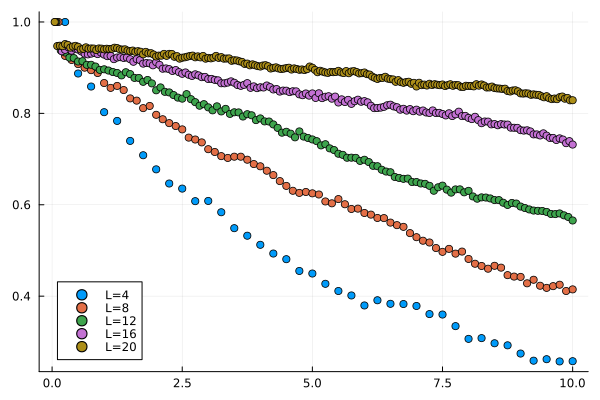

In [276]:
plt = plot()
p = 0.07
for L in 4:4:20
    T = 10L
    xs = collect(1:T)/L
    ys = [1 - 2mean(data[(L,p)][:,t,:,:]) for t in 1:T]
    plot!(plt, xs, ys, seriestype=:scatter, label="L=$L")
end
plt

In [266]:
plt = plot()
p = 0.1
for L in 4:4:20
    T = 10L
    xs = collect(1:T)/L
    ys1 = [mean((1 .- 2mean(data[(L,p)][:,t,:,:],dims=(2,3))) .^ 2) for t in 1:T]
    ys2 = [(1 - 2mean(data[(L,p)][:,t,:,:]))^2 for t in 1:T]
    plot!(plt, xs, L*(ys1-ys2), seriestype=:scatter, label="L=$L")
end
plt

LoadError: KeyError: key (16, 0.1) not found

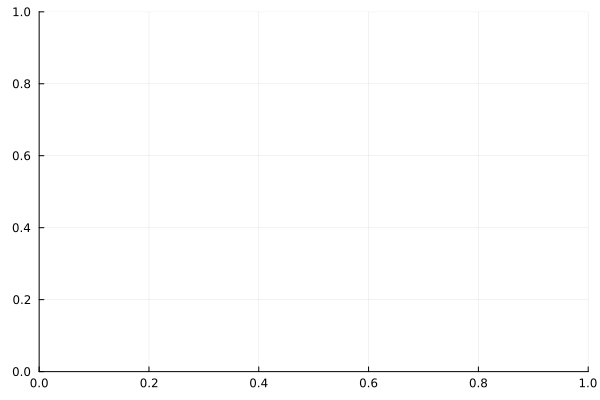

In [260]:
plt = plot()
for L in 8:4:2
    T = 10L
    xs = 0.0:0.001:0.1
    ys1 = [mean((1 .- 2mean(data[(L,p)][:,end,:,:],dims=(2,3))) .^ 2) for p in xs]
    ys2 = [(1 - 2mean(data[(L,p)][:,end,:,:]))^2 for p in xs]
    plot!(plt, xs, L^2*(ys1-ys2), seriestype=:scatter, label="L=$L")
end
plt

In [197]:
L = 3
vertical_checks = BitMatrix([1 0 0
                             0 0 0
                             0 0 0])
horizontal_checks = BitMatrix([0 0 0
                               0 1 0
                               0 0 0])

# detect_charges(vertical_checks, horizontal_checks)

new_vertical, new_horizontal = heal(vertical_checks, horizontal_checks)

(Bool[0 0 0; 0 0 0; 0 0 0], Bool[0 0 0; 0 0 0; 0 0 0])

In [198]:
build_domains(new_vertical, new_horizontal)

3×3 BitMatrix:
 0  0  0
 0  0  0
 0  0  0

In [199]:
sample(1:2,2,replace=false)

2-element Vector{Int64}:
 2
 1

In [200]:

ρ = initialstate(4)
ρ = noiselayer(ρ, 0.1)
ρ = BitMatrix([0 0 0 0
               0 1 1 0
               0 0 0 0
               0 0 0 0])

4×4 BitMatrix:
 0  0  0  0
 0  1  1  0
 0  0  0  0
 0  0  0  0

In [216]:
vertical_checks, horizontal_checks = measure(ρ, 0.05)
build_domains(heal(vertical_checks, horizontal_checks)...)

4×4 BitMatrix:
 0  0  0  0
 0  1  1  0
 0  0  0  0
 0  0  0  0

In [86]:
pairings.mate[4]

1

In [89]:
pairings.weight

4.0

In [ ]:
## vertical_checks .⊻ horizontal_checks .⊻ circshift(vertical_checks,(0,-1)) .⊻ circshift(horizontal_checks,(-1,0))

In [62]:
vertical_checks 

4×4 BitMatrix:
 0  1  1  0
 0  1  1  0
 0  0  0  0
 0  0  1  0

In [63]:
horizontal_checks

4×4 BitMatrix:
 0  0  0  0
 1  0  1  0
 0  0  0  0
 0  0  0  0

In [65]:
struct MatchingResult{U<:Real}
    weight::U
    mate::Vector{Int}
end

In [68]:
function minimum_weight_perfect_matching end

function minimum_weight_perfect_matching(
    g::Graph, w::Dict{E,U}, cutoff, kws...
) where {U<:Real,E<:Edge}
    wnew = Dict{E,U}()
    for (e, c) in w
        if c <= cutoff
            wnew[e] = c
        end
    end
    return minimum_weight_perfect_matching(g, wnew; kws...)
end

function minimum_weight_perfect_matching(
    g::Graph, w::Dict{E,U}; tmaxscale=10.0
) where {U<:AbstractFloat,E<:Edge}
    wnew = Dict{E,Int32}()
    cmax = maximum(values(w))
    cmin = minimum(values(w))

    tmax = typemax(Int32) / tmaxscale # /10 is kinda arbitrary,
    # hopefully high enough to not occur in overflow problems
    for (e, c) in w
        wnew[e] = round(Int32, (c - cmin) / max(cmax - cmin, 1) * tmax)
    end
    match = minimum_weight_perfect_matching(g, wnew)
    weight = zero(U)
    for i in 1:nv(g)
        j = match.mate[i]
        if j > i
            weight += w[E(i, j)]
        end
    end
    return MatchingResult(weight, match.mate)
end

function minimum_weight_perfect_matching(g::Graph, w::Dict{E,U}) where {U<:Integer,E<:Edge}
    m = BlossomV.Matching(nv(g))
    for (e, c) in w
        BlossomV.add_edge(m, src(e) - 1, dst(e) - 1, c)
    end
    BlossomV.solve(m)

    mate = fill(-1, nv(g))
    totweight = zero(U)
    for i in 1:nv(g)
        j = BlossomV.get_match(m, i - 1) + 1
        mate[i] = j <= 0 ? -1 : j
        if i < j
            totweight += w[Edge(i, j)]
        end
    end
    return MatchingResult(totweight, mate)
end

minimum_weight_perfect_matching (generic function with 3 methods)